In [1]:
# Загрузка необходимых библиотек и модулей

import warnings
warnings.filterwarnings("ignore")

import os
import joblib
import kagglehub

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno

import pandas as pd
import numpy as np
import random

from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torchinfo import summary

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# Загрузка датасета

path = kagglehub.dataset_download("new-york-city/ny-2015-street-tree-census-tree-data")
print(os.listdir(path))

['2015-street-tree-census-tree-data.csv', 'socrata_metadata.json', 'StreetTreeCensus2015TreesDataDictionary20161102.pdf']


In [3]:
df = pd.read_csv(path + '/2015-street-tree-census-tree-data.csv')
df.head()

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
0,180683,348711,2015-08-27T00:00:00.000,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,4073900,New York,40.723092,-73.844215,1027431.148,202756.7687,29.0,739.0,4052307.0,4.022210e+09
1,200540,315986,2015-09-03T00:00:00.000,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,4097300,New York,40.794111,-73.818679,1034455.701,228644.8374,19.0,973.0,4101931.0,4.044750e+09
2,204026,218365,2015-09-05T00:00:00.000,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.717581,-73.936608,1001822.831,200716.8913,34.0,449.0,3338310.0,3.028870e+09
3,204337,217969,2015-09-05T00:00:00.000,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.713537,-73.934456,1002420.358,199244.2531,34.0,449.0,3338342.0,3.029250e+09
4,189565,223043,2015-08-30T00:00:00.000,21,0,OnCurb,Alive,Good,Tilia americana,American linden,...,3016500,New York,40.666778,-73.975979,990913.775,182202.4260,39.0,165.0,3025654.0,3.010850e+09


In [4]:
# Сводные статистики

df.describe()

,tree_id,block_id,tree_dbh,stump_diam,postcode,community board,borocode,cncldist,st_assem,st_senate,boro_ct,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
count,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,6.837880e+05,683788.000000,683788.000000,6.837880e+05,683788.000000,677269.000000,677269.000000,6.742290e+05,6.742290e+05
mean,365205.011085,313793.096236,11.279787,0.432463,10916.246044,343.505404,3.358500,29.943181,50.791583,20.615781,3.404914e+06,40.701261,-73.924060,1.005280e+06,194798.424625,30.027330,11957.368422,3.495439e+06,3.413414e+09
std,208122.092902,114839.024312,8.723042,3.290241,651.553364,115.740601,1.166746,14.328531,18.966520,7.390844,1.175863e+06,0.090311,0.123583,3.428505e+04,32902.061114,14.301717,30745.739811,1.193275e+06,1.174892e+09
min,3.000000,100002.000000,0.000000,0.000000,83.000000,101.000000,1.000000,1.000000,23.000000,10.000000,1.000201e+06,40.498466,-74.254965,9.133493e+05,120973.792200,1.000000,1.000000,1.000000e+06,0.000000e+00
25%,186582.750000,221556.000000,4.000000,0.000000,10451.000000,302.000000,3.000000,19.000000,33.000000,14.000000,3.011700e+06,40.631928,-73.980500,9.896578e+05,169515.153700,19.000000,202.000000,3.031991e+06,3.011240e+09
50%,366214.500000,319967.000000,9.000000,0.000000,11214.000000,402.000000,4.000000,30.000000,52.000000,21.000000,4.008100e+06,40.700612,-73.912911,1.008386e+06,194560.252500,30.000000,516.000000,4.020352e+06,4.008560e+09
75%,546170.250000,404624.000000,16.000000,0.000000,11365.000000,412.000000,4.000000,43.000000,64.000000,25.000000,4.103202e+06,40.762228,-73.834910,1.029991e+06,217019.571950,43.000000,1417.000000,4.263123e+06,4.105700e+09
max,722694.000000,999999.000000,450.000000,140.000000,11697.000000,503.000000,5.000000,51.000000,87.000000,36.000000,5.032300e+06,40.912918,-73.700488,1.067248e+06,271894.092100,51.000000,157903.000000,5.515124e+06,5.080500e+09


In [5]:
# Информация о датасете

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 45 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tree_id           683788 non-null  int64  
 1   block_id          683788 non-null  int64  
 2   created_at        683788 non-null  object 
 3   tree_dbh          683788 non-null  int64  
 4   stump_diam        683788 non-null  int64  
 5   curb_loc          683788 non-null  object 
 6   status            683788 non-null  object 
 7   health            652172 non-null  object 
 8   spc_latin         652169 non-null  object 
 9   spc_common        652169 non-null  object 
 10  steward           652173 non-null  object 
 11  guards            652172 non-null  object 
 12  sidewalk          652172 non-null  object 
 13  user_type         683788 non-null  object 
 14  problems          652124 non-null  object 
 15  root_stone        683788 non-null  object 
 16  root_grate        68

In [6]:
print('Количество дублирующихся записей - ', len(df[df.duplicated()].values))

Количество дублирующихся записей -  0


<Axes: >

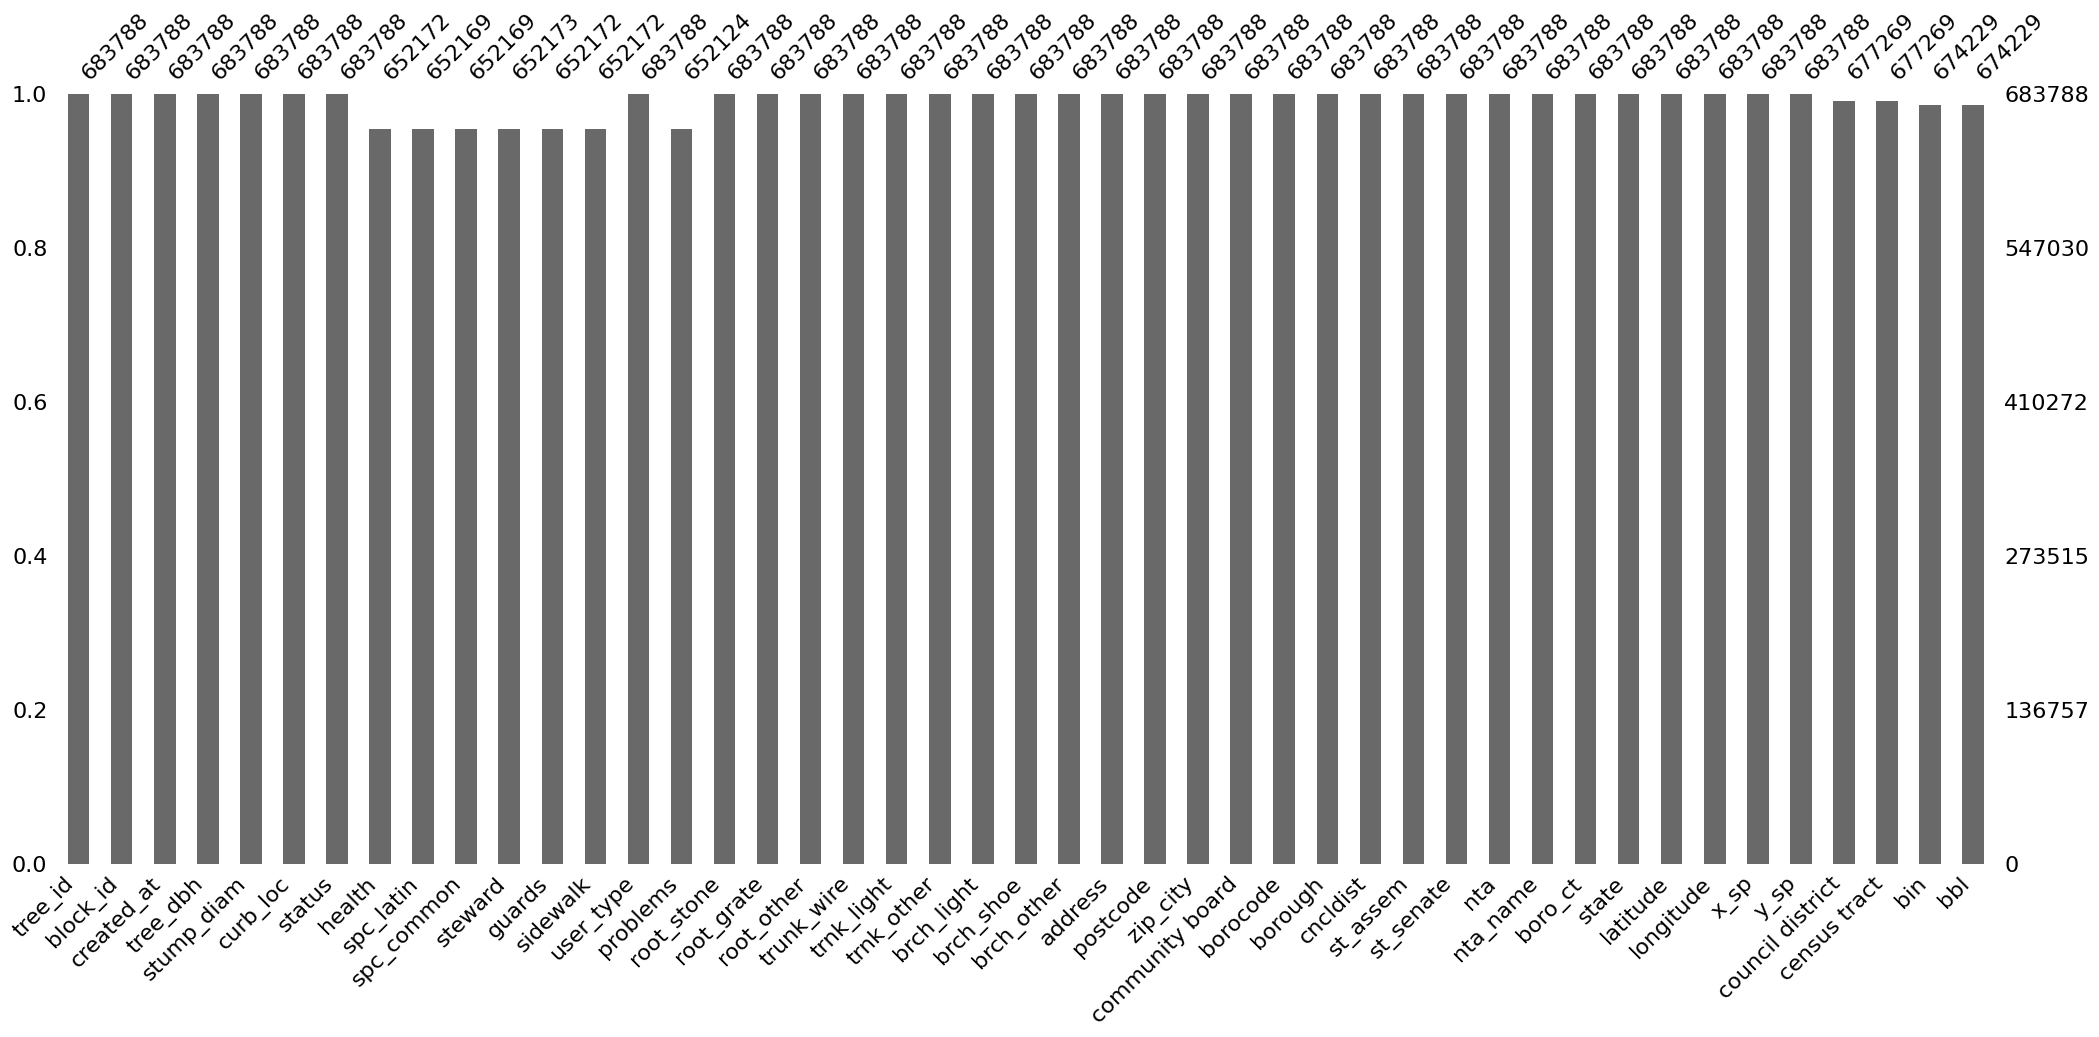

In [7]:
# Пропуски в данных

msno.bar(df)

In [8]:
def print_useful_rows_info(df):
    print('Количество полностью заполненных объектов из всей выборки:', len(df.dropna()))
    print('Процент полностью заполненных объектов из всей выборки:', round(len(df.dropna()) / len(df) * 100, 2))
    missing_values = ((df.isna().sum() / len(df)) * 100).sort_values(ascending=False)
    print('Пропуски в столбцах:')
    for i in range(0, len(missing_values)):
        if missing_values[i] > 0:
            print(f'{missing_values.index[i]} - {df.loc[:, missing_values.index[i]].isna().sum()} -'
                  f' {round(df.loc[:, missing_values.index[i]].isna().sum() / len(df) * 100, 2)}%')
print_useful_rows_info(df)

Количество полностью заполненных объектов из всей выборки: 642961
Процент полностью заполненных объектов из всей выборки: 94.03
Пропуски в столбцах:
problems - 31664 - 4.63%
spc_common - 31619 - 4.62%
spc_latin - 31619 - 4.62%
health - 31616 - 4.62%
sidewalk - 31616 - 4.62%
guards - 31616 - 4.62%
steward - 31615 - 4.62%
bbl - 9559 - 1.4%
bin - 9559 - 1.4%
council district - 6519 - 0.95%
census tract - 6519 - 0.95%


In [9]:
# Проверим строки с отсутствующими данными о состоянии дерева

df[df.health.isnull()]

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
37,211205,302080,2015-09-09T00:00:00.000,0,16,OnCurb,Stump,NaN,NaN,NaN,...,4009500,New York,40.774993,-73.922037,1.005843e+06,221637.1447,22.0,95.0,4019192.0,4.008740e+09
57,187807,506266,2015-08-29T00:00:00.000,0,0,OnCurb,Dead,NaN,NaN,NaN,...,2042500,New York,40.871927,-73.882349,1.016788e+06,256965.9677,11.0,415.0,2016979.0,2.032990e+09
196,208322,222858,2015-09-07T00:00:00.000,10,0,OnCurb,Dead,NaN,NaN,NaN,...,3044500,New York,40.705742,-73.917849,1.007027e+06,196407.8326,37.0,445.0,3073739.0,3.032390e+09
209,209058,415850,2015-09-08T00:00:00.000,6,0,OnCurb,Dead,NaN,NaN,NaN,...,5012806,New York,40.559061,-74.106038,9.547857e+05,142975.3788,50.0,12806.0,5056700.0,5.040740e+09
239,203597,301947,2015-09-04T00:00:00.000,0,15,OnCurb,Stump,NaN,NaN,NaN,...,4011700,New York,40.772483,-73.909073,1.009435e+06,220726.1774,22.0,117.0,4015864.0,4.008060e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683693,156162,108193,2015-08-18T00:00:00.000,3,0,OffsetFromCurb,Dead,NaN,NaN,NaN,...,1015801,New York,40.785136,-73.951109,9.977894e+05,225326.7807,5.0,15801.0,1048443.0,1.015230e+09
683695,170888,231931,2015-08-24T00:00:00.000,0,5,OnCurb,Stump,NaN,NaN,NaN,...,3079400,New York,40.647154,-73.955619,9.965658e+05,175055.1250,40.0,794.0,3117748.0,3.051270e+09
683697,177922,410634,2015-08-26T00:00:00.000,0,17,OnCurb,Stump,NaN,NaN,NaN,...,5017600,New York,40.528544,-74.165246,9.383125e+05,131882.7120,51.0,176.0,5081744.0,5.063570e+09
683698,193791,208850,2015-09-01T00:00:00.000,3,0,OnCurb,Dead,NaN,NaN,NaN,...,3038600,New York,40.590385,-73.972892,9.917788e+05,154370.9206,47.0,386.0,3194400.0,3.071730e+09


In [10]:
# Удаляем строки, в которых отсутствует значение целевой переменной

df = df.dropna(subset=['health'])
df.shape

(652172, 45)

In [11]:
print_useful_rows_info(df)

Количество полностью заполненных объектов из всей выборки: 642961
Процент полностью заполненных объектов из всей выборки: 98.59
Пропуски в столбцах:
bbl - 9103 - 1.4%
bin - 9103 - 1.4%
census tract - 6206 - 0.95%
council district - 6206 - 0.95%
problems - 49 - 0.01%
spc_latin - 5 - 0.0%
spc_common - 5 - 0.0%
guards - 1 - 0.0%
sidewalk - 1 - 0.0%


In [12]:
df[df.spc_latin.isnull() & df.spc_common.isnull()]

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
356613,562532,315837,2016-05-19T00:00:00.000,4,0,OnCurb,Alive,Good,NaN,NaN,...,4099100,New York,40.791332,-73.803610,1038630.469,227641.3712,19.0,991.0,4103675.0,4.045570e+09
427541,630814,323764,2016-07-18T00:00:00.000,11,0,OnCurb,Alive,Poor,NaN,NaN,...,4148300,New York,40.771945,-73.750414,1053380.635,220615.7964,19.0,1483.0,4168471.0,4.080630e+09
431417,651014,308540,2016-08-02T00:00:00.000,40,0,OnCurb,Alive,Good,NaN,NaN,...,4000800,New York,40.686902,-73.859411,1023240.372,189564.7945,32.0,8.0,4185286.0,4.089630e+09
608632,47941,346795,2015-07-03T00:00:00.000,5,0,OnCurb,Alive,Good,NaN,NaN,...,4067100,New York,40.723484,-73.880296,1017429.853,202884.0907,30.0,671.0,4067282.0,4.029350e+09
656960,150745,515014,2015-08-16T00:00:00.000,3,0,OnCurb,Alive,Good,NaN,NaN,...,2042000,New York,40.894521,-73.858255,1023438.408,265207.8056,11.0,420.0,2068064.0,2.049940e+09


In [13]:
"""
Данные spc_latin и spc_common отсутствуют в одних и тех же строках, что не позволяет восстановить эти данные на 
основе других строк в датасете. Их количество незначительно (менее 0,01% от всего датасета), поэтому  удаляем их 
из датасета. Количество пропусков в столбцах problems, guards, sidewalk также незначительно и невозможно восстановить,
их также удаляем
"""

df = df.dropna(subset=['problems', 'guards', 'sidewalk', 'spc_latin', 'spc_common'])
df.shape

(652118, 45)

In [14]:
# Рассмотрим другие признаки с пропусками подробнее

df[['council district', 'cncldist', 'boro_ct', 'census tract', 'bin','bbl']]

,council district,cncldist,boro_ct,census tract,bin,bbl
0,29.0,29,4073900,739.0,4052307.0,4.022210e+09
1,19.0,19,4097300,973.0,4101931.0,4.044750e+09
2,34.0,34,3044900,449.0,3338310.0,3.028870e+09
3,34.0,34,3044900,449.0,3338342.0,3.029250e+09
4,39.0,39,3016500,165.0,3025654.0,3.010850e+09
...,...,...,...,...,...,...
683783,34.0,34,3051900,519.0,3062513.0,3.023690e+09
683784,29.0,29,4070700,707.0,4075448.0,4.031810e+09
683785,50.0,50,5020100,201.0,5011657.0,5.004080e+09
683786,15.0,15,2023502,23502.0,2007757.0,2.028120e+09


In [15]:
print(f"Процент совпадения значений в council district и cncldist:\n"
      f"{(df[df['council district'] == df['cncldist']].shape[0] / df.shape[0]) * 100:.2f}%")

Процент совпадения значений в council district и cncldist:
98.19%


In [16]:
"""
Из данных видно, что council district и cncldist фактически представляют собой одни и те же значения, а census tract
является частью boro_ct - кода участка, в который попадает дерево. Соответственно между этими парами признаков будет
высокая корреляция. Столбцы с пропусками удалим из датасета.
Столбцы bin и bbl отсутствуют в описании к датасету, судя информации в свободном доступе они являются  кодами районов, 
кварталов и зданий NYC и дублируют информацию в других столбцах. Удаляем признаки с пропусками bin и bbl.
"""

df.drop(columns=['council district', 'census tract', 'bin', 'bbl'], inplace=True)
df.shape

(652118, 41)

In [17]:
# Проверяем количество уникальных значений в признаках

df.nunique()

tree_id            652118
block_id           100693
created_at            483
tree_dbh              145
stump_diam              1
curb_loc                2
status                  1
health                  3
spc_latin             132
spc_common            132
steward                 4
guards                  4
sidewalk                2
user_type               3
problems              232
root_stone              2
root_grate              2
root_other              2
trunk_wire              2
trnk_light              2
trnk_other              2
brch_light              2
brch_shoe               2
brch_other              2
address            395393
postcode              191
zip_city               48
community board        59
borocode                5
borough                 5
cncldist               51
st_assem               65
st_senate              26
nta                   188
nta_name              188
boro_ct              2152
state                   1
latitude           645116
longitude   

In [18]:
"""
Признаки state, stump_diam и status после удаления строк с пропусками имеют 1 уникальное значение и 
бесполезны для построения модели.
"""

df.drop(columns=['state', 'stump_diam', 'status'], inplace=True)
df.head()

,tree_id,block_id,created_at,tree_dbh,curb_loc,health,spc_latin,spc_common,steward,guards,...,cncldist,st_assem,st_senate,nta,nta_name,boro_ct,latitude,longitude,x_sp,y_sp
0,180683,348711,2015-08-27T00:00:00.000,3,OnCurb,Fair,Acer rubrum,red maple,None,None,...,29,28,16,QN17,Forest Hills,4073900,40.723092,-73.844215,1027431.148,202756.7687
1,200540,315986,2015-09-03T00:00:00.000,21,OnCurb,Fair,Quercus palustris,pin oak,None,None,...,19,27,11,QN49,Whitestone,4097300,40.794111,-73.818679,1034455.701,228644.8374
2,204026,218365,2015-09-05T00:00:00.000,3,OnCurb,Good,Gleditsia triacanthos var. inermis,honeylocust,1or2,None,...,34,50,18,BK90,East Williamsburg,3044900,40.717581,-73.936608,1001822.831,200716.8913
3,204337,217969,2015-09-05T00:00:00.000,10,OnCurb,Good,Gleditsia triacanthos var. inermis,honeylocust,None,None,...,34,53,18,BK90,East Williamsburg,3044900,40.713537,-73.934456,1002420.358,199244.2531
4,189565,223043,2015-08-30T00:00:00.000,21,OnCurb,Good,Tilia americana,American linden,None,None,...,39,44,21,BK37,Park Slope-Gowanus,3016500,40.666778,-73.975979,990913.775,182202.4260


In [19]:
print_useful_rows_info(df)

Количество полностью заполненных объектов из всей выборки: 652118
Процент полностью заполненных объектов из всей выборки: 100.0
Пропуски в столбцах:


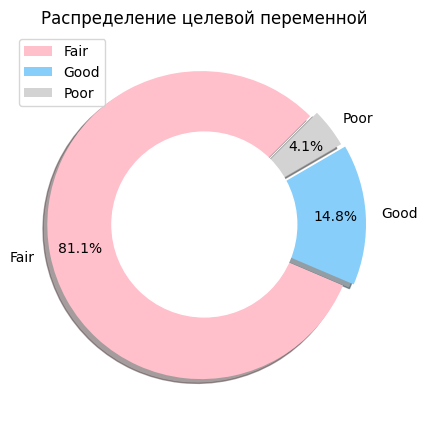

In [20]:
# График распределения целевой переменной

size = df.health.value_counts()
colors = ['pink', 'lightskyblue', 'lightgray']
labels = df.health.unique().tolist()
explode = [0.02, 0.05, 0.03] 

plt.figure(figsize=(5, 5))
donut = plt.Circle((0,0), 0.6, color = 'white')
plt.pie(size, colors = colors, labels = labels, shadow = True, 
        explode = explode, autopct = '%.1f%%', pctdistance=0.8, startangle=45)

plt.title('Распределение целевой переменной', fontsize = 12)
plt.legend(loc='upper left')
p = plt.gcf()
p.gca().add_artist(donut)
plt.show()

In [21]:
# Из графика видим, что есть дисбаланс классов целевой переменной, учтем это на этапе построения модели.

In [22]:
# Рассмотрим содержимое признака problems

df.problems.value_counts()

None                                                                          426276
Stones                                                                         95671
BranchLights                                                                   29452
Stones,BranchLights                                                            17808
RootOther                                                                      11418
                                                                               ...  
Stones,RootOther,WiresRope,TrunkLights,TrunkOther,BranchLights,BranchOther         1
MetalGrates,RootOther,WiresRope,TrunkLights,BranchLights,BranchOther               1
MetalGrates,WiresRope,TrunkLights,BranchLights,BranchOther                         1
Stones,MetalGrates,TrunkLights,TrunkOther                                          1
MetalGrates,TrunkOther,Sneakers                                                    1
Name: problems, Length: 232, dtype: int64

In [23]:
"""
Подробнее рассмотрим фичи problems, root_stone, root_grate, root_other, trunk_wire, 
trnk_light, trnk_other, brch_light, brch_shoe и brch_other
"""

problems_cols = ['problems', 'root_stone', 'root_grate', 'root_other', 'trunk_wire', 
                 'trnk_light', 'trnk_other', 'brch_light', 'brch_shoe', 'brch_other']
df[problems_cols].head()

,problems,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other
0,None,No,No,No,No,No,No,No,No,No
1,Stones,Yes,No,No,No,No,No,No,No,No
2,None,No,No,No,No,No,No,No,No,No
3,Stones,Yes,No,No,No,No,No,No,No,No
4,Stones,Yes,No,No,No,No,No,No,No,No


 ##### Столбцы root_ , trunk_ и brch_ представляют собой бинаризированные признаки о наличии/отсутствии определенной проблемы из problems, дублируя эту информацию, поэтому удалим также столбец problems из обучающей выборки.

In [24]:
"""
Определяем числовые и категориальные признаки, на которых будет обучаться модель.
Исключаем столбцы с дублирующимися географические данными, такими как borough (коды соответствуют названиям в borocode), 
координаты latitude и longitude дублируют в некоторой степени x_sp и y_sp (координаты на местном плане), nta, которые
дублируют информацию о названиях NTA (nta_name), уникальные id районов и др.
"""

num_cols = [
    'tree_dbh', 
    'x_sp', 
    'y_sp'
]

cat_cols = [
    'spc_common',
    'steward',
    'guards',
    'boro_ct', 
    'borocode', 
    'community board'

]

bin_cols = ['curb_loc', 'sidewalk', 'root_stone', 'root_grate', 'root_other', 'trunk_wire', 
            'trnk_light', 'trnk_other', 'brch_light', 'brch_shoe', 'brch_other']

Признак tree_dbh
Нижняя граница -  -11.5 
Верхняя граница -  32.5 
Количество выбросов -  15378


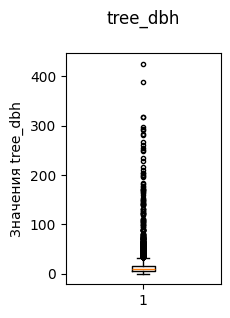

----------------------------------------
Признак x_sp
Нижняя граница -  928966.4323750001 
Верхняя граница -  1090465.452175 
Количество выбросов -  17712


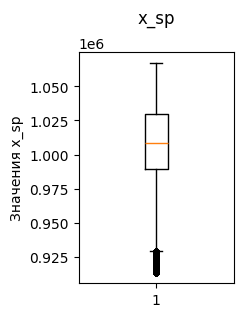

----------------------------------------
Признак y_sp
Нижняя граница -  98198.4350625 
Верхняя граница -  288187.8039625 
Количество выбросов -  0


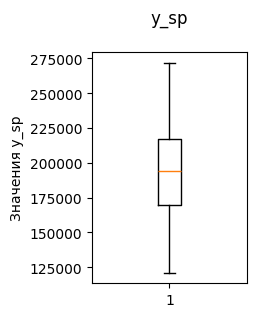

----------------------------------------


In [25]:
# Проверяем выбросы в числовых признаках

def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

for feat in num_cols:
    print('Признак', feat)
    boundaries = calculate_outliers(df[feat])
    outlier = (df[feat] < boundaries[0]) | (df[feat] > boundaries[1])
    print('Нижняя граница - ', boundaries[0], '\nВерхняя граница - ', boundaries[1], 
          '\nКоличество выбросов - ', outlier.sum())
    
    plt.figure(figsize=(2, 3))
    plt.boxplot(df[feat], sym='.')
    plt.ylabel('Значения ' + feat) 
    plt.title(feat + '\n')
    plt.show();
    print(f'{"-" * 40}')

In [26]:
"""
Отклонение в такой степени координат вполне возможны, но значения диаметра дерева 50 дюймов (1,3 м) и более выглядит
ошибочным. Заменим значения диаметра дерева, выходящие за границы интервквартильного размаха по его верхней границе
"""

boundaries = calculate_outliers(df.tree_dbh)
outliers = df.tree_dbh > boundaries[1]
df.loc[outliers, 'tree_dbh'] = boundaries[1]

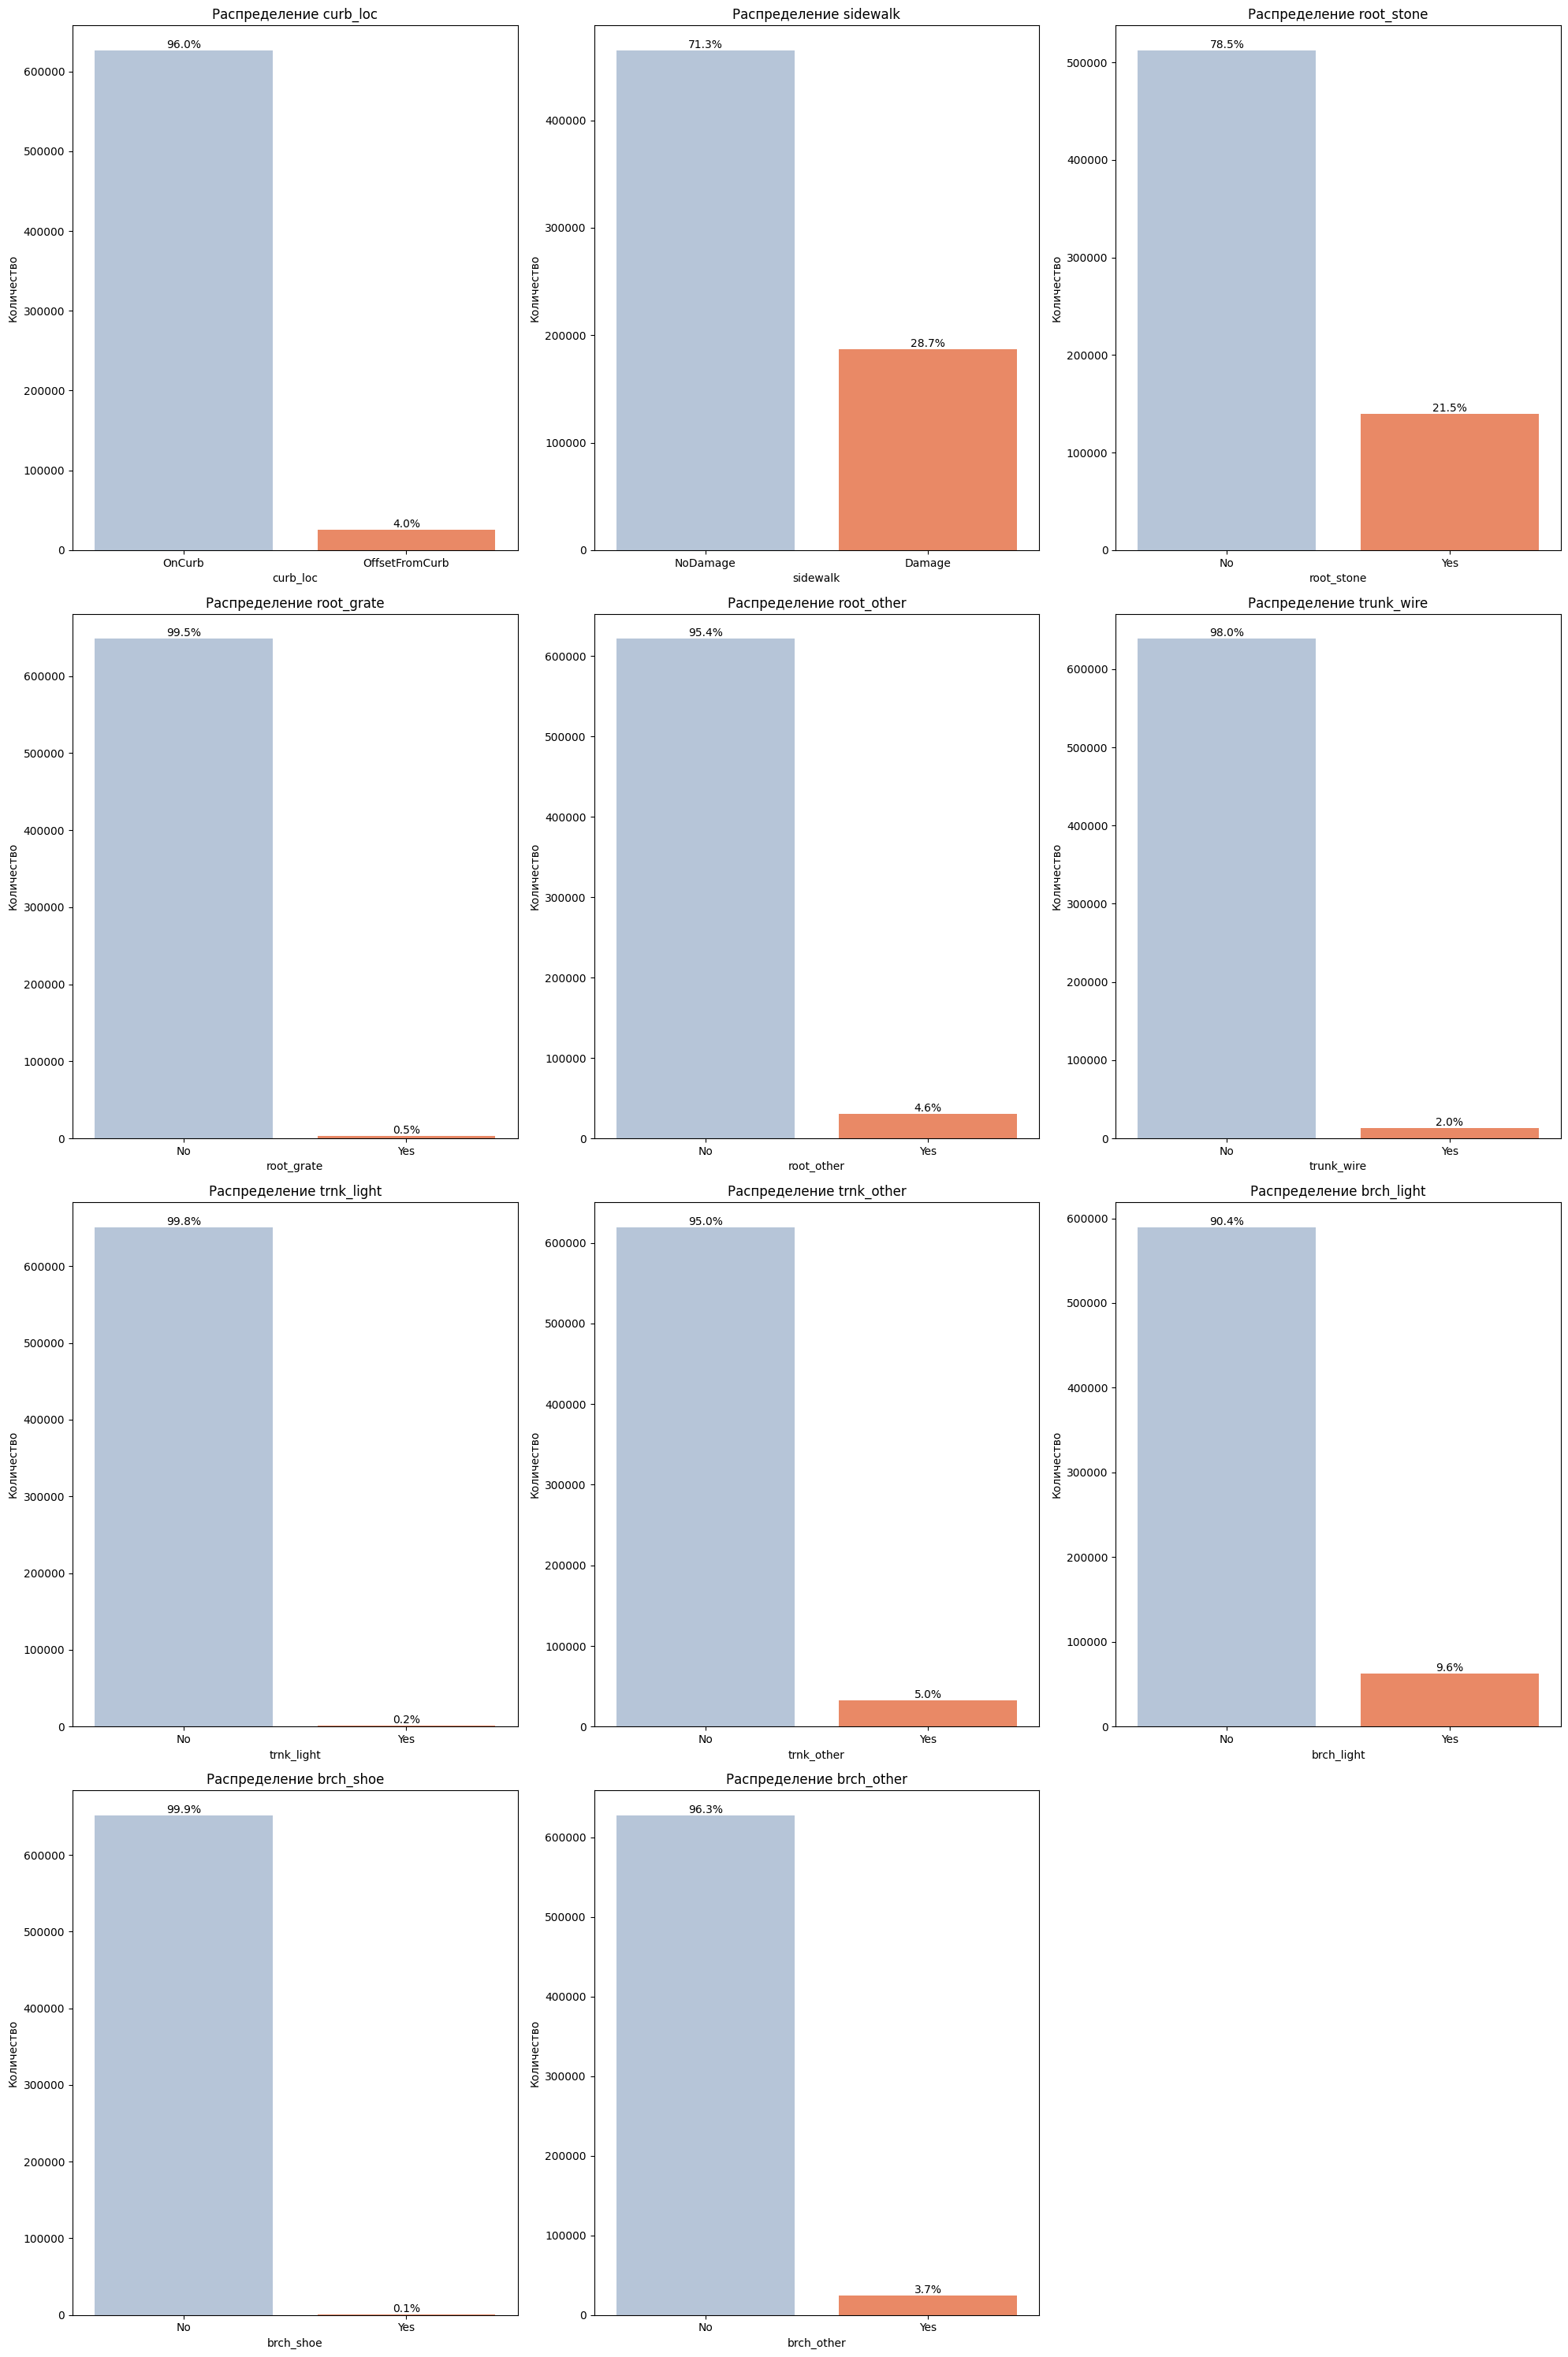

In [27]:
# Графики распределения бинарных признаков

plt.figure(figsize=(20, 30))

for i, col in enumerate(bin_cols):
    plt.subplot(4, 3, i+1)
    sns.countplot(x=col, data=df, palette=['lightsteelblue', 'coral'])
    
    total = len(df)
    counts = df[col].value_counts()
    for p in plt.gca().patches:
        height = p.get_height()
        percentage = 100 * height / total
        plt.text(p.get_x() + p.get_width() / 2., height + 1, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Количество')

plt.tight_layout()
plt.show()

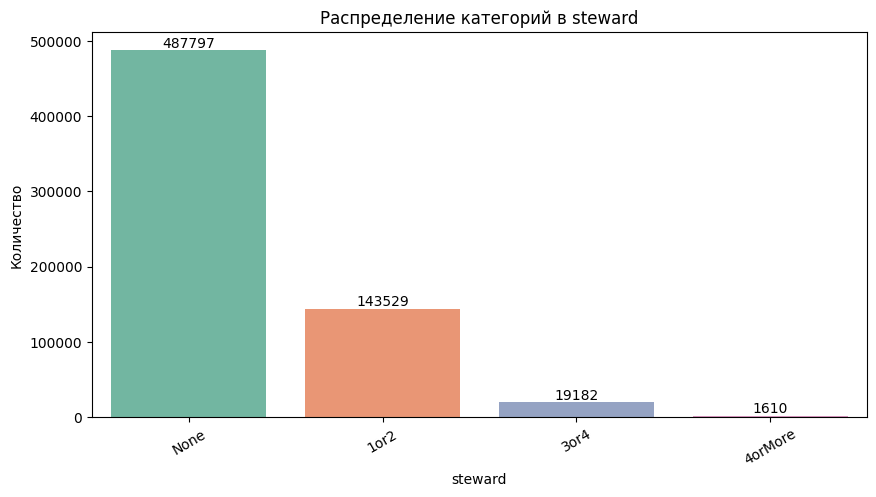

In [41]:
# Распределение категорий некоторых категориальных признаков

def plot_distribution(df, col, show_lbl=True, x_fontsize=10, chart_size=(10, 5), rotation=30):
    
    plt.figure(figsize=chart_size)

    sorted_counts = df[col].value_counts().sort_values(ascending=False)
    sorted_order = sorted_counts.index
    
    sns.countplot(x=col, data=df, palette='Set2', order=sorted_order)

    if show_lbl:
        for p in plt.gca().patches:
            height = p.get_height()
            plt.text(p.get_x() + p.get_width() / 2., height + 1, 
                     f'{int(height)}', ha='center', va='bottom')

    plt.title(f'Распределение категорий в {col}')
    plt.xlabel(col)
    plt.ylabel('Количество')
    plt.xticks(rotation=rotation, fontsize=x_fontsize)
    plt.show()

plot_distribution(df, 'steward')

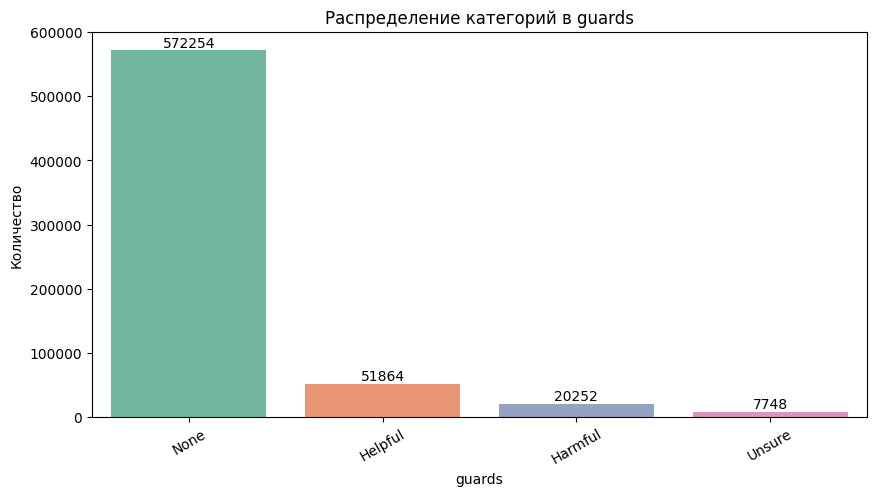

In [42]:
plot_distribution(df, 'guards')

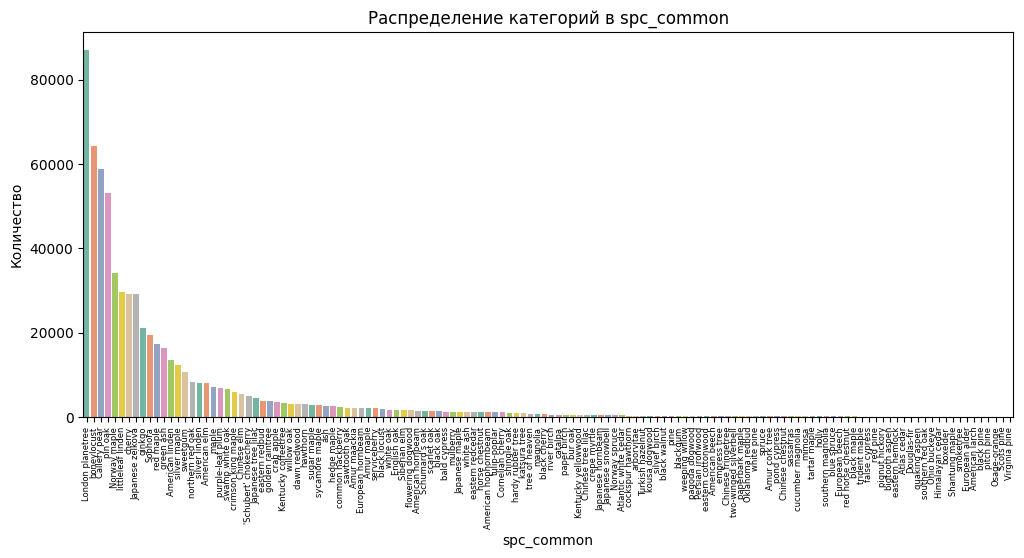

In [43]:
plot_distribution(df, 'spc_common', show_lbl=False, x_fontsize=6, chart_size=(12,5), rotation=90)

#### Преобразование числовых признаков

In [30]:
# Преобразование бинарных признаков

for col in bin_cols:
    labels = df[col].unique().tolist()
    df[col] = df[col].apply(lambda x: 0 if x == labels[0] else 1)
df[bin_cols].head()

,curb_loc,sidewalk,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other
0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,0,1,1,0,0,0,0,0,0,0,0
4,0,1,1,0,0,0,0,0,0,0,0


In [31]:
# Стандартизация признаков

std_scaler = StandardScaler()
std_scaler.fit(df[num_cols])
std_scaled = std_scaler.transform(df[num_cols])
std_cols = ['std_' + c for c in num_cols]
df[std_cols] = std_scaled
df[std_cols].head()

,std_tree_dbh,std_x_sp,std_y_sp
0,-1.060775,0.648951,0.244955
1,1.163042,0.853408,1.032167
2,-1.060775,-0.096406,0.182925
3,-0.195957,-0.079014,0.138145
4,1.163042,-0.413925,-0.380068


#### Кодирование категориальных признаков

In [32]:
df[cat_cols].nunique()

spc_common          132
steward               4
guards                4
boro_ct            2152
borocode              5
community board      59
dtype: int64

In [33]:
"""
Признаки steward, borocode, guards имеют небольшое количество уникальных значений, закодируем их с помощью ohe. 
Также поступим с бинарными признаками. Остальные фичи имеют достаточно большое количество уникальных значений, 
что приведет к созданию слишком большой разреженной матрицы, что усложнит обучение и значительно увеличит требование 
к ресурсам для обучения модели. Чтобы избежать этого, закодируем признаки с использованием target_encoder, который 
кодирует категориальные признаки числами, отражающими условное математическое ожидание целевой переменной.
"""

ohe_encoder = OneHotEncoder(drop='first', sparse=False, dtype='int8')
ohe_encoder.fit(df[['steward', 'guards', 'borocode']])
ohe_data = ohe_encoder.transform(df[['steward', 'guards', 'borocode']])
ohe_cols = list(ohe_encoder.get_feature_names_out())
df[ohe_cols] = ohe_data
df.head()

,tree_id,block_id,created_at,tree_dbh,curb_loc,health,spc_latin,spc_common,steward,guards,...,steward_3or4,steward_4orMore,steward_None,guards_Helpful,guards_None,guards_Unsure,borocode_2,borocode_3,borocode_4,borocode_5
0,180683,348711,2015-08-27T00:00:00.000,3.0,0,Fair,Acer rubrum,red maple,None,None,...,0,0,1,0,1,0,0,0,1,0
1,200540,315986,2015-09-03T00:00:00.000,21.0,0,Fair,Quercus palustris,pin oak,None,None,...,0,0,1,0,1,0,0,0,1,0
2,204026,218365,2015-09-05T00:00:00.000,3.0,0,Good,Gleditsia triacanthos var. inermis,honeylocust,1or2,None,...,0,0,0,0,1,0,0,1,0,0
3,204337,217969,2015-09-05T00:00:00.000,10.0,0,Good,Gleditsia triacanthos var. inermis,honeylocust,None,None,...,0,0,1,0,1,0,0,1,0,0
4,189565,223043,2015-08-30T00:00:00.000,21.0,0,Good,Tilia americana,American linden,None,None,...,0,0,1,0,1,0,0,1,0,0


In [34]:
df[std_cols + bin_cols + ohe_cols]

,std_tree_dbh,std_x_sp,std_y_sp,curb_loc,sidewalk,root_stone,root_grate,root_other,trunk_wire,trnk_light,...,steward_3or4,steward_4orMore,steward_None,guards_Helpful,guards_None,guards_Unsure,borocode_2,borocode_3,borocode_4,borocode_5
0,-1.060775,0.648951,0.244955,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
1,1.163042,0.853408,1.032167,0,1,1,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
2,-1.060775,-0.096406,0.182925,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,-0.195957,-0.079014,0.138145,0,1,1,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
4,1.163042,-0.413925,-0.380068,0,1,1,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683783,1.657223,-0.244327,0.134416,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
683784,-0.566593,0.548766,0.157284,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
683785,0.051133,-1.710960,-0.888992,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
683786,-0.319503,0.172267,1.659402,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,0


In [35]:
# Преобразование целевой переменной

lbl_encoder = LabelEncoder()
df['health'] = lbl_encoder.fit_transform(df['health'])

y = torch.tensor(df['health'].values, dtype=torch.long)

In [36]:
# Кодирование категориальных признаков с помощью TargetEncoder

categorical_cols = ['spc_common', 'community board', 'boro_ct']
te_cols = [col+'_encoding' for col in categorical_cols]

target_encoder = TargetEncoder()
df[te_cols] = target_encoder.fit_transform(df[categorical_cols].astype(str), df['health'])

In [37]:
train_cols = std_cols + bin_cols + ohe_cols + te_cols

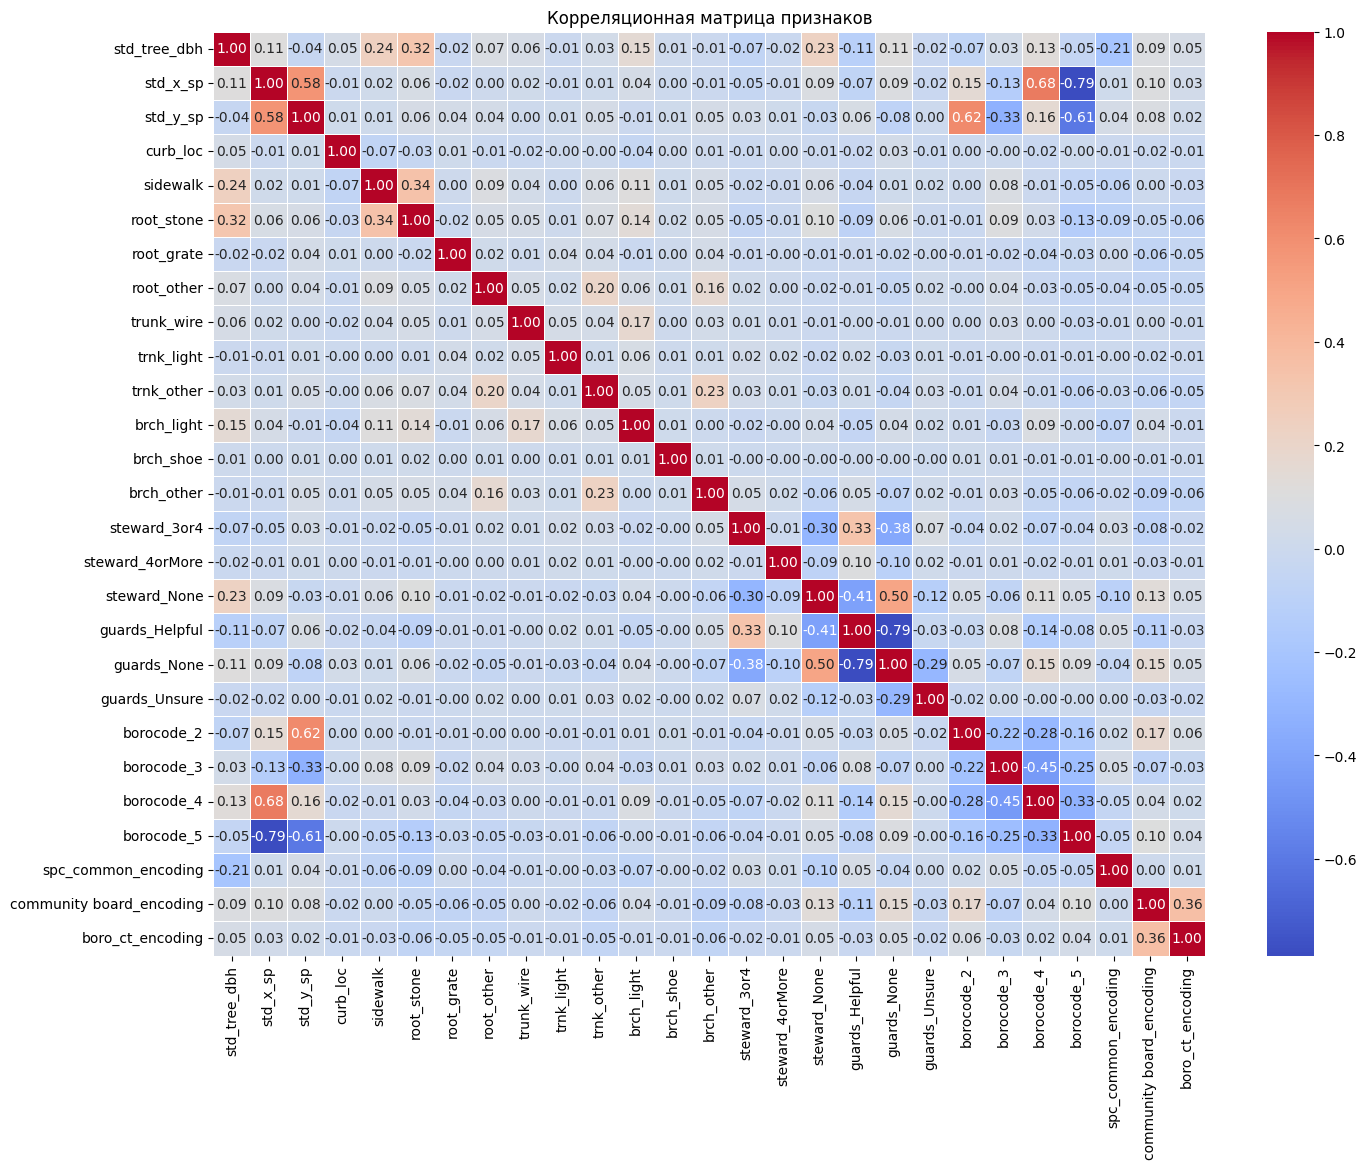

In [38]:
# Корреляция признаков

corr_matrix = df[train_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Корреляционная матрица признаков")
plt.show()

In [39]:
# Преобразуем обучающие данные в тензоры

X = torch.tensor(df[train_cols].values, dtype=torch.float32)

print(X.shape)

torch.Size([652118, 27])


In [40]:
# Разделение на тренировочную и валидационную выборки

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [41]:
# Вычисление весов классов для использования их при обучении модели для преодоления влияния дисбаланса классов

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [42]:
# Перенос данных на gpu

X_train = X_train.to(device)
X_val = X_val.to(device)
y_train = y_train.to(device)
y_val = y_val.to(device)

In [43]:
# Задаем размер батча

batch_size = 4096

In [44]:
# Создание Dataset и DataLoader

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

##### Обоснование выбора архитектуры модели и решений

В проекте выбрана архитектура многослойный перцептрон (MLP). Использование MLP архитектуры для табличных данных обосновано тем, что она эффективно работает с категориальными и числовыми признаками, учитывая их нелинейные взаимодействия. При работе с признаками без временной и пространственных связей, MLP способен эффективно моделировать сложные зависимости в данных, а использование архитектур сверточных или рекуррентных сетей необосновано.

Архитектура MLP реализована с 3 скрытыми слоями, постепенно уменьшающейся размерности, которая способствует сжатию и обобщению информации, предотвращая переобучение и снижая вычислительные затраты. 

После каждого полносвязного слоя выполняется нормализация батча, что улучшает сходимость за счет стабилизации распределения активаций, уменьшая внутреннее ковариационное смещение.

В качестве функции активации выбрана ReLU в связи с простотой вычислений и отсутствием проблемы исчезающего градиента, что способствует более быстрой и стабильной сходимости.

Для предотвращения переобучения и более устойчивого обучений после каждого слоя применны Dropout.

В связи с значительным дисбалансом классов целевой переменной, была выбрана кастомная Loss-функция Focal Loss, которая уменьшает вес легко классифицируемых примеров и увеличивает вес сложных, помогая модели лучше распознавать минорные классы.

В качестве оптимизатора выбрано Adam, который сочетает преимущества AdaGrad и RMSProp и обеспечивает быструю сходимость.

Для более плавного обучения применен Learning Rate Scheduler для уменьшения скорости обучения через фиксированные интервалы, что помогает избежать застревания в локальных минимумах и колебаний около глобального минимума, обеспечивая более стабильную сходимость.

В качестве метрики выбрана F1-macro, которая позволяет учитывать качество классификации для каждого класса независимо, что важно при дисбалансе классов и обеспечивает равное внимание всем классам, включая минорные.

In [45]:
# Создаем класс модели с архитектурой MLP

class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_dims, output_size, dropout):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dims[1], hidden_dims[2]),
            nn.BatchNorm1d(hidden_dims[2]),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dims[2], output_size)
        )

    def forward(self, x):
        return self.model(x)

In [46]:
# Определяем параметры модели

input_size = X.shape[1]
hidden_dims = [512, 256, 128]
output_size = 3
n_epochs = 25
dropout = 0.3

In [47]:
# Создаем модель MLP

mlp_model = MLPModel(input_size, hidden_dims, output_size, dropout)
summary(mlp_model, input_size=(1, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
MLPModel                                 [1, 3]                    --
├─Sequential: 1-1                        [1, 3]                    --
│    └─Linear: 2-1                       [1, 512]                  14,336
│    └─BatchNorm1d: 2-2                  [1, 512]                  1,024
│    └─ReLU: 2-3                         [1, 512]                  --
│    └─Dropout: 2-4                      [1, 512]                  --
│    └─Linear: 2-5                       [1, 256]                  131,328
│    └─BatchNorm1d: 2-6                  [1, 256]                  512
│    └─ReLU: 2-7                         [1, 256]                  --
│    └─Dropout: 2-8                      [1, 256]                  --
│    └─Linear: 2-9                       [1, 128]                  32,896
│    └─BatchNorm1d: 2-10                 [1, 128]                  256
│    └─ReLU: 2-11                        [1, 128]                  

In [48]:
"""
Создаем класс для вычисления кастомной Focal loss-функции, которая более оптимальна для работы с несбалансированными данными.
Она представляет из себя стандартную Cross-Entropy Loss с добавлением коэффициента, уменьшающего влияние легко 
классифицируемых примеров и усиливающего влияние сложных.
""" 

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        p_t = torch.exp(-ce_loss)
        focal_loss = (1 - p_t) ** self.gamma * ce_loss

        if self.alpha is not None:
            focal_loss *= self.alpha[targets]

        return focal_loss.mean()

In [49]:
# Задаем оптимизатор, скорость обучения и loss-функцию. Настраиваем lr scheduler для более плавного и стабильного обучения

learning_rate = 0.1
optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
criterion = FocalLoss(alpha=class_weights, gamma=3)

mlp_model = mlp_model.to(device)
criterion = criterion.to(device)

In [50]:
# Функция для обучения модели
# Оценку модели будем производить по метрике f1 с макроусреднением, чтобы объективно оценить модель на всех классах.

def train(model, train_loader, optimizer, criterion):
    epoch_loss = 0
    model.train()
    train_preds = []
    train_lbls = []

    for inputs, labels in train_loader:
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward(retain_graph=True)
        optimizer.step()

        epoch_loss += loss.item()
        train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        train_lbls.extend(labels.cpu().numpy())

    f1 = f1_score(train_lbls, train_preds, average='macro')
    return epoch_loss / len(train_loader), f1

In [51]:
# Функция для валидации модели

def evaluate(model, val_loader, criterion):
    epoch_loss = 0
    model.eval()
    val_preds = []
    val_lbls = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()
            val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            val_lbls.extend(labels.cpu().numpy())

    f1 = f1_score(val_lbls, val_preds, average='macro')
    return epoch_loss / len(val_loader), f1

In [52]:
# Обучаем модель и сохраняем лучшую по метрике f1

train_losses = []
train_f1_scores = []
val_losses = []
val_f1_scores = []
best_f1 = -float('inf')

for epoch in range(n_epochs):
    train_loss, train_f1 = train(mlp_model, train_loader, optimizer, criterion)
    val_loss, val_f1 = evaluate(mlp_model, val_loader, criterion)
    scheduler.step()
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train F1: {train_f1:.3f}, Val Loss: {val_loss:.3f}, Val F1: {val_f1:.3f}')
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(mlp_model.state_dict(), "best_mlp_model.pth")
        print(f"Save best model with Val F1: {val_f1:.3f}")
        
    train_losses.append(train_loss)
    train_f1_scores.append(train_f1)
    val_losses.append(val_loss)
    val_f1_scores.append(val_f1)

Epoch: 01, Train Loss: 0.391, Train F1: 0.208, Val Loss: 0.320, Val F1: 0.175
Save best model with Val F1: 0.175
Epoch: 02, Train Loss: 0.321, Train F1: 0.225, Val Loss: 0.316, Val F1: 0.384
Save best model with Val F1: 0.384
Epoch: 03, Train Loss: 0.313, Train F1: 0.307, Val Loss: 0.314, Val F1: 0.409
Save best model with Val F1: 0.409
Epoch: 04, Train Loss: 0.307, Train F1: 0.353, Val Loss: 0.301, Val F1: 0.367
Epoch: 05, Train Loss: 0.305, Train F1: 0.361, Val Loss: 0.302, Val F1: 0.328
Epoch: 06, Train Loss: 0.303, Train F1: 0.370, Val Loss: 0.297, Val F1: 0.342
Epoch: 07, Train Loss: 0.303, Train F1: 0.370, Val Loss: 0.297, Val F1: 0.390
Epoch: 08, Train Loss: 0.301, Train F1: 0.376, Val Loss: 0.296, Val F1: 0.408
Epoch: 09, Train Loss: 0.301, Train F1: 0.380, Val Loss: 0.294, Val F1: 0.392
Epoch: 10, Train Loss: 0.301, Train F1: 0.377, Val Loss: 0.296, Val F1: 0.408
Epoch: 11, Train Loss: 0.298, Train F1: 0.380, Val Loss: 0.291, Val F1: 0.384
Epoch: 12, Train Loss: 0.297, Train F

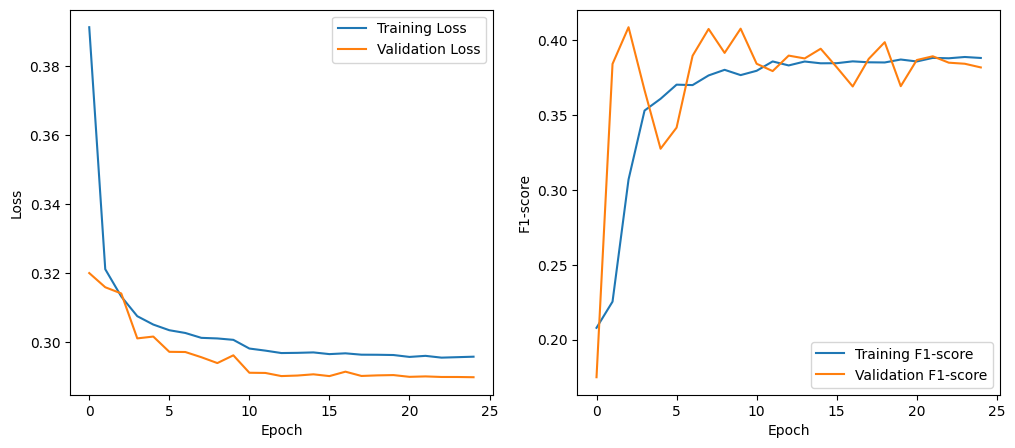

In [53]:
# Выводим графики обучения модели

plt.figure(figsize=(12, 5))

#Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#F-score
plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label='Training F1-score')
plt.plot(val_f1_scores, label='Validation F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.legend()

plt.show()

In [54]:
# Функция для вычисления метрик и визуализации результатов

def evaluate_model(model, iterator, model_name="MLP", class_names=lbl_encoder.classes_.astype(str)):
    model.eval()
    all_predictions = []
    all_labels = []
    epoch_loss = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()
            all_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Вычисляем метрики
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f"=== {model_name} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 254)
    
    print("Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_names))
    
    # Визуализация матрицы ошибок
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

=== MLP ===
Accuracy: 0.7638
Precision: 0.7268
Recall: 0.7638
F1 Score: 0.7423
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

        Fair       0.26      0.15      0.19     19300
        Good       0.84      0.91      0.87    105761
        Poor       0.17      0.15      0.16      5363

    accuracy                           0.76    130424
   macro avg       0.42      0.40      0.41    130424
weighted avg       0.73      0.76      0.74    130424



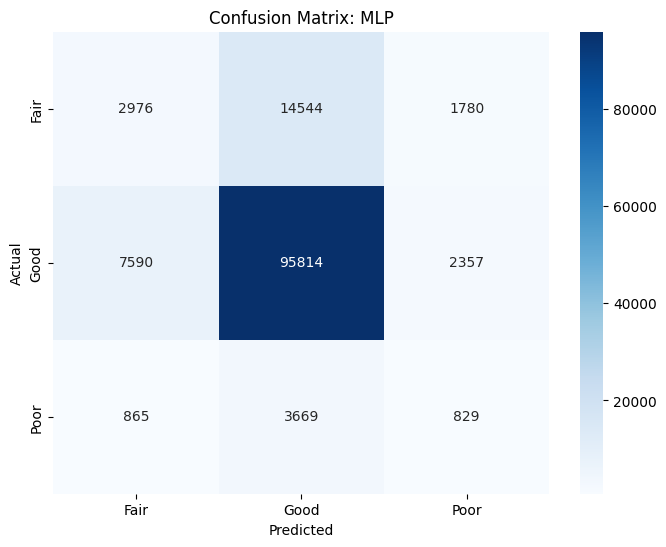

In [55]:
# Загружаем сохраненую лучшую модель и проверяем ее метрики

mlp_model = MLPModel(input_size, hidden_dims, output_size, dropout)
mlp_model.load_state_dict(torch.load("best_mlp_model.pth"))
mlp_model = mlp_model.to(device)
criterion = criterion.to(device)

evaluate_model(mlp_model, val_loader, model_name="MLP")

In [56]:
# Сохранение кодировщиков и модели для инференса

joblib.dump(target_encoder, "app/encoders/target_encoder.pkl")
joblib.dump(std_scaler, "app/encoders/std_scaler.pkl")
joblib.dump(ohe_encoder, "app/encoders/ohe_encoder.pkl")
joblib.dump(lbl_encoder, "app/encoders/lbl_encoder.pkl")

model_scripted = torch.jit.script(mlp_model)
model_scripted.save('app/saved_model/mlp_model.ckpt')